# Train a NN to predict which volume a track will hit in next

Taking a series of real-space coordinates forming the start of a true track, I want to predict which volume the next hit will fall in (or if there will not be any more hits). I will train an LSTM to take as inputs a sequence of hit coordinates, and output a one-hot encoding of the prediction for the volume in which the next hit will fall.

__Currently, the problem is that taking samples of tracks from the data takes a very long time. It needs to be sped up by a couple of orders of magnitude.__

In [1]:
import numpy as np
import numpy.random as rand
import pandas as pd
from trackml.dataset import load_event
from trackml.randomize import shuffle_hits
from trackml.score import score_event
import matplotlib.pyplot as plt

In [2]:
hits, cells, particles, truth = load_event('./training_data/event000001000')

I'm going to add lots of redundant coordinate information. It might help.

In [5]:
# Numpy array of hit x,y,z coordinates
hits_xyz = hits.values[:,1:4]
hits_r = np.sqrt(np.power(hits_xyz[:,0],2) + np.power(hits_xyz[:,1],2))
# I am adding two phi coordinates, offset by 90 degrees.
# This is because the NN might have trouble when a track goes through the discontinuity.
# With two phi coordinates, the NN can rely on at least one of them being continuous for a small displacement.
# It is just guesswork. Can see what happens if I remove some of these variables later.
hits_phi_x = np.sign(hits_xyz[:,1]) * np.arccos(hits_xyz[:,0] / hits_r)
hits_phi_y = np.sign(- hits_xyz[:,0]) * np.arccos(hits_xyz[:,1] / hits_r)
hits_theta = np.arctan(hits_xyz[:,2] / hits_r)

# Combine all coords into a single array
hits_xyzrphiphitheta = np.concatenate((hits_xyz,
                                      np.reshape(hits_r,(-1,1)),
                                      np.reshape(hits_phi_x,(-1,1)),
                                      np.reshape(hits_phi_y,(-1,1)),
                                      np.reshape(hits_theta,(-1,1))),
                                      axis=1)

# One-hot encoding of detector volume.
# I added an additional volume, '0'.
# This is because I want the NN to predict which volume the next hit will be in.
# Sometimes there will not be a next hit.
# The additional volume is when the answer should be 'no more hits in the track'.
onehot_volume = {7:np.array([1,0,0,0,0,0,0,0,0,0]),
                8:np.array([0,1,0,0,0,0,0,0,0,0]),
                9:np.array([0,0,1,0,0,0,0,0,0,0]),
                12:np.array([0,0,0,1,0,0,0,0,0,0]),
                13:np.array([0,0,0,0,1,0,0,0,0,0]),
                14:np.array([0,0,0,0,0,1,0,0,0,0]),
                16:np.array([0,0,0,0,0,0,1,0,0,0]),
                17:np.array([0,0,0,0,0,0,0,1,0,0]),
                18:np.array([0,0,0,0,0,0,0,0,1,0]),
                0:np.array([0,0,0,0,0,0,0,0,0,1])}

hits_vol = hits.values[:,4].astype(int)

#This is a list of the unique track ids
track_unique_ids = np.unique(truth.values[:,1])
rand.shuffle(track_unique_ids)

## Train a NN to predict which volume the track will hit in next

In [16]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Masking
from keras.layers import SimpleRNN, LSTM, GRU, TimeDistributed
from keras import metrics
from keras.preprocessing.sequence import pad_sequences
from IPython import display

This function, create_batch, will pick out N random tracks (where N = batchsize) from the event, and will return:

1) track_hits_list_coords

This is a list of tracks. Each track is a list of hit coordinates. These are padded with zero-entries at the end, so that each track has the same number of hits, so the short tracks will gain dummy zero-hits to make them as long as the long tracks. This is necessary in order to construct the NN properly, but these padded hits will be masked out when we come to use the NN.

2) hits_vol_onehot

This is a list of tracks. Each track is a list of the one-hot encoding for the volume in which the NEXT hit will lie (including volume 0 if there is no next hit). Again, these are padded with zero-entries at the end.


__Currently, the problem is that this function takes a very long time (a few seconds for a batch of size 100 on my laptop). It needs to be sped up by a couple of orders of magnitude.__

In [7]:
def create_batch(batchsize = 100):
    trackhitslist = [truth.values[truth.values[:,1] == track_unique_id,0]
                     for track_unique_id in track_unique_ids[rand.randint(len(track_unique_ids),size=batchsize)]]
    track_hits_list_coords = [hits_xyzrphiphitheta[hits.astype(int)-1] for hits in trackhitslist]
    track_hits_list_coords = pad_sequences(track_hits_list_coords,padding='post',dtype=track_hits_list_coords[0].dtype)

    track_hits_list_vols = [hits_vol[hits.astype(int)-1] for hits in trackhitslist]

    hits_vol_onehot = [np.array([onehot_volume[hit] for hit in track_hits_list])
                                for track_hits_list in track_hits_list_vols]
    hits_vol_onehot = [np.append(hits,np.array([onehot_volume[0]]),axis=0) for hits in hits_vol_onehot]
    hits_vol_onehot = pad_sequences(hits_vol_onehot,padding='post')
    hits_vol_onehot = np.delete(hits_vol_onehot,0,axis=1)
    
    return track_hits_list_coords, hits_vol_onehot

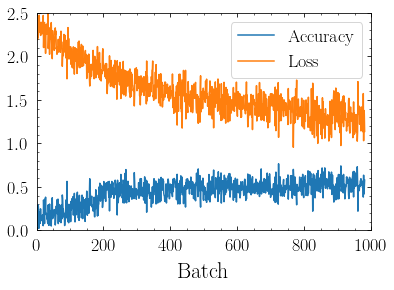

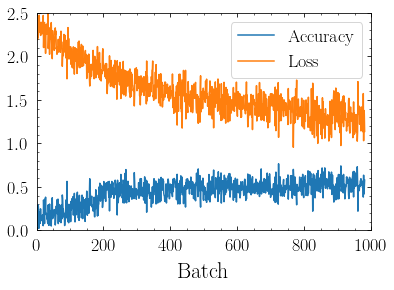

In [14]:
batchsize = 10
numbatches = 1000

# define LSTM
model = Sequential()
#model.add(Masking(mask_value=0., input_dim=len(hits_xyzrphiphitheta[0])))
input_dim=len(hits_xyzrphiphitheta[0])
model.add(Masking(mask_value=0., input_shape=(None,input_dim)))
model.add(LSTM(20, return_sequences=True))
model.add(TimeDistributed(Dense(10, activation='softmax')))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

acc = []
loss = []

for batch in range(numbatches):
    x, y = create_batch(batchsize)
    model_hist = model.fit(x=x,y=y,batch_size = batchsize,epochs=1,verbose=0)
    acc.append(model_hist.history['acc'][0])
    loss.append(model_hist.history['loss'][0])
    if batch%20 == 0:
        plt.close('all')
        plt.plot(acc,color='C0',label='Accuracy')
        plt.plot(loss,color='C1',label='Loss')
        plt.xlim(0,numbatches)
        plt.ylim(0,2.5)
        plt.xlabel('Batch')
        plt.legend()
        display.clear_output(wait=True)
        display.display(plt.gcf())

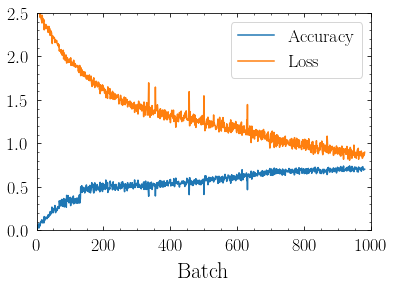

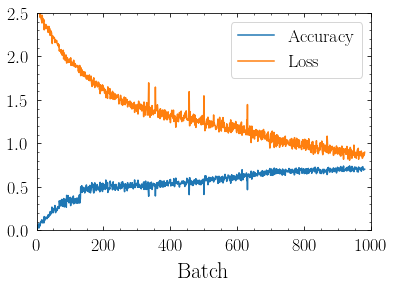

In [28]:
batchsize = 100
numbatches = 1000

# define LSTM
model = Sequential()
#model.add(Masking(mask_value=0., input_dim=len(hits_xyzrphiphitheta[0])))
input_dim=len(hits_xyzrphiphitheta[0])
model.add(Masking(mask_value=0., input_shape=(None,input_dim)))
model.add(LSTM(20, return_sequences=True))
model.add(TimeDistributed(Dense(10, activation='softmax')))
# def top_3_categorical_accuracy(ytrue, ypred):
#     return metrics.top_k_categorical_accuracy(ytrue, ypred, k=3)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

acc = []
loss = []

for batch in range(numbatches):
    x, y = create_batch(batchsize)
    model_hist = model.fit(x=x,y=y,batch_size = batchsize,epochs=1,verbose=0)
    acc.append(model_hist.history['acc'][0])
    loss.append(model_hist.history['loss'][0])
    if batch%20 == 0:
        plt.close('all')
        plt.plot(acc,color='C0',label='Accuracy')
        plt.plot(loss,color='C1',label='Loss')
        plt.xlim(0,numbatches)
        plt.ylim(0,2.5)
        plt.xlabel('Batch')
        plt.legend()
        display.clear_output(wait=True)
        display.display(plt.gcf())

Accuracy is slowly increasing, and loss slowly decreasing. But it would take too long to complete this, until I have a much faster way of doing create_batch.